This Jupyter Notebook simulates the following:
- Generates three model planets: Uniform, limb-darkened and a volcano model.
- Simulates an occultation via the slicing method outlined in the report.
- Plots the lightcurve and generates JWST data.
- Reconstructs an image from the lightcurve.

To run a slice, all above slices must also have been run such that the Kernal contains the necessary information. This may be optimised further to not require this process at some stage in the future.

It is highly recommended to choose 'run all' - allowing ~10 minutes for the entire notebook to complete.

# Import and Initialise

In [2]:
# Imports the necessary modules.
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.utils.data import download_file
from time import time
from sys import stdout
import matplotlib.ticker as mticker
from scipy.interpolate import interp1d
pi=np.pi

In [3]:
# Defines the Trappist-1 Values: 
R_Earth=6.3781e6
R_Sun=6.957e8
AU=1.5e11
T_S=2559
P=1.51087081*(3600*24)
R_S=0.117*R_Sun
R_P=1.086*R_Earth
a=11.11e-3*AU
inc=89.65
velocity = 2*pi*a/P
t_transit=36.4*60
b=0.126
trans_duration=36.4*60
scale_param=20.50
k=R_P/R_S

# Generate Model

## With and without volcano

This will generate three models, both with and without a volcano, whilst simultaneously maintaining the flux between each model.

Starting image generation ...
areas: 70685.8347058 1696460.03294
Nratio:  0.1 totalconstant:  1178096106.47
Adding specified offset ...
Filename: generatedimage1521806665.37.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (1500, 1500)   float64   
<type 'numpy.ndarray'>
(1500, 1500)


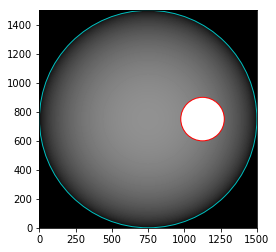

Success.


In [4]:
### Constants for the model image:
x_dimension=1500
y_dimension=1500

# The flux values are arbitrary:
peak_flux=1000
total_flux=1e9
###

###Volcano constants:
enable_volcano=True # Enables a volcano on the third model.
enable_hollow=False # Enables a hollow circular volcano.
use_flux_ratios=True # Enables a ratio to be set defining how bright the volcano is wrt the entire planet.
N_volcanoes=1 # Defines the number of volcanoes.
if N_volcanoes>1 and enable_hollow==True: raise Exception
    
# Define the width of each volcano, and the hollow centre if using a circular feature.
x_width_volcano=300.
y_width_volcano=300.
x_width_vol_hollow=600.
y_width_vol_hollow=600.

# Define the location of each volcano. This is measured from the centre.
# Due to coding challenges, the value you entre is double the distance. IE: x=1000 plots x=500.
x_offset=[750.]
y_offset=[0.]
if (len(x_offset) != len(y_offset)) or (N_volcanoes!=len(y_offset)): raise Exception('Number of volcanoes error...')
    
# If using flux ratios, define it here:
Nratio=0.1

# Defines and plots the circle of the planet.
fig, ax = plt.subplots()
plt.axis([0,x_dimension,0,y_dimension])
x_min = 0
x_max = x_dimension
y_min = 0
y_max = y_dimension
circle_x = (x_max-x_min)/2.
circle_y = (y_max-y_min)/2.
circ=plt.Circle((circle_x,circle_y), radius=x_dimension/2., color='c', fill=False)
ax.add_artist(circ)

# Plots the volcanoes:
loopvar={}
for i in range(N_volcanoes):
    loopvar["x_min{0}".format(i)]=0
    loopvar["x_max{0}".format(i)]=x_dimension+x_offset[i]
    loopvar["y_min{0}".format(i)]=0
    loopvar["y_max{0}".format(i)]=y_dimension+y_offset[i]
    #x_min2 = 0
    #x_max2 = x_dimension+x_offset2
    #y_min2 = 0
    #y_max2 = y_dimension+y_offset2
    loopvar["circle_x{0}".format(i)]=(loopvar["x_max"+str(i)]-loopvar["x_min"+str(i)])/2.
    loopvar["circle_y{0}".format(i)]=(loopvar["y_max"+str(i)]-loopvar["y_min"+str(i)])/2.
    #circle_x2 = (x_max2-x_min2)/2.
    #circle_y2 = (y_max2-y_min2)/2.
    circ=plt.Circle((loopvar["circle_x"+str(i)],loopvar["circle_y"+str(i)]), radius=x_width_volcano/2., color='r', fill=False)
    ax.add_artist(circ)

# If hollow enabled, plot the hollow circle.
if enable_hollow == True:
    x_minh = 0
    x_maxh = x_dimension+x_offset[0]
    y_minh = 0
    y_maxh = y_dimension+y_offset[0]
    circle_xh = (x_maxh-x_minh)/2.
    circle_yh = (y_maxh-y_minh)/2.
    circh=plt.Circle((circle_xh,circle_yh), radius=x_width_vol_hollow/2., color='m', fill=False)
    ax.add_artist(circh)
else:
    x_width_vol_hollow, y_width_vol_hollow, circle_xh, circle_yh = 0,0,0,0

# Initialise variables to generate models.
# uniform = limb-darkened
# nolimb = non-limb-darkened
test_amount, nDone, total_pixels, test=0, 0, 0, 0
x, y=[0,0], [0,0]
stime = time()
values_test = np.zeros(shape=(x_dimension,y_dimension))
values_test_nolimb = np.zeros(shape=(x_dimension,y_dimension))
values_test_uniform = np.zeros(shape=(x_dimension,y_dimension))
values_test_novol = np.zeros(shape=(x_dimension,y_dimension))
radius=x_dimension/2.

# Begin model generation
print "Starting image generation ..."

for i in range(x_dimension): #loop through x pixels
    for j in range(y_dimension): #loop through y pixels
        d=(i - circle_x)**2 + (j - circle_y)**2 #calculate distance of pixel to circle centre
        if d**0.5 < x_dimension/2.: #determine if distance lies within radial size of planet
            theta=np.arcsin(d**0.5/radius) #calculate angular distance
            values_test[i,j]=np.cos(theta)*(peak_flux) #assign cos limb darkening law from centre
            for k in range(N_volcanoes): #determine flux of planet outside of volcano regions
                d=(i - loopvar["circle_x"+str(k)])**2 + (j - loopvar["circle_y"+str(k)])**2 
                d_hollow=(i - circle_xh)**2 + (j - circle_yh)**2
                if d**0.5 < x_width_volcano/2. and d_hollow**0.5 >= x_width_vol_hollow/2.: continue
                else: values_test_novol[i,j]=np.cos(theta)*(peak_flux)


# Determine ratio of planet and volcano if using ratio method:
total_constant=np.sum(values_test.flat)
if use_flux_ratios==False: volcano_flux=1500
elif use_flux_ratios==True:
    volcanoarea=pi*(x_width_volcano/2)**2
    planetarea=pi*(x_dimension/2)**2-volcanoarea
    print "areas:",volcanoarea,planetarea
    integrated_area=np.sum(values_test_novol.flat)
    if Nratio!=1 and Nratio!=0:
        volcano_flux=Nratio*total_constant
        volcano_flux_pp=volcano_flux/volcanoarea
        planet_flux=total_constant*(1-Nratio)
        ratio_flux=planet_flux/integrated_area
    elif Nratio==1:
        planet_flux=0
        volcano_flux=total_constant
        volcano_flux_pp=volcano_flux/volcanoarea
        planet_flux=total_constant*(1-Nratio)
        ratio_flux=planet_flux/integrated_area
    elif Nratio==0:
        planet_flux=total_constant
        volcano_flux_pp,volcano_flux=0,0
        planet_flux=total_constant*(1-Nratio)
        ratio_flux=planet_flux/integrated_area
    print "Nratio: ", Nratio, "totalconstant: ", total_constant
    
    for i in range(x_dimension): #loop through x pixels
        for j in range(y_dimension): #loop through y pixels
            d=(i - circle_x)**2 + (j - circle_y)**2 #calculate distance of pixel to circle centre
            if d**0.5 < x_dimension/2.: #determine if distance lies within radial size of planet
                #newvalue=values_test[i,j]+delta_flux_pp
                #if newvalue>=0: values_test[i,j] = newvalue
                #else: values_test[i,j] = 0.0
                values_test[i,j]=values_test[i,j]*ratio_flux
else: raise Exception('Volcano flux not set...')
        
# Repeat process for volcano location
if enable_volcano==True:
    print "Adding specified offset ..." 
    pixelcounter=0.0
    pixelcounter2=0.0
    for i in range(x_dimension):
        for j in range(y_dimension):
            for k in range(N_volcanoes):
                d=(i - loopvar["circle_x"+str(k)])**2 + (j - loopvar["circle_y"+str(k)])**2 
                d_hollow=(i - circle_xh)**2 + (j - circle_yh)**2
                if d**0.5 < x_width_volcano/2. and d_hollow**0.5 >= x_width_vol_hollow/2.:
                    pixelcounter+=volcano_flux_pp-values_test[i,j]
    # Determines extra flux per pixel to add to other models so the total flux is equal.
    extra_flux=pixelcounter/(pi*(x_dimension*0.5)**2) 
else:
    extra_flux=0
            
# Add the extra flux to the limb-darkened planet
for i in range(x_dimension):
    for j in range(y_dimension):
        d=(i - circle_x)**2 + (j - circle_y)**2 
        if d**0.5 < x_dimension/2.: 
            values_test_uniform[i,j]=values_test[i,j]+extra_flux
        
# Determine the average flux value and assign this for the no-limb-darkening planet
average_flux_value=np.sum(values_test_uniform.flat)/(pi*(x_dimension/2.)**2)

# Generate no-limb planet
for i in range(x_dimension): 
    for j in range(y_dimension): 
        d=(i - circle_x)**2 + (j - circle_y)**2 
        if d**0.5 < x_dimension/2.:
            values_test_nolimb[i,j]=average_flux_value
            
# Save model fits files
values_test1 = np.transpose(values_test_uniform)
hdu = fits.PrimaryHDU(values_test1)
hdu.writeto('uniformimage'+str(stime)+'.fits')
model_image_uniform='uniformimage'+str(stime)+'.fits'

values_test_nolimb = np.transpose(values_test_nolimb)
hdu = fits.PrimaryHDU(values_test_nolimb)
hdu.writeto('nolimbimage'+str(stime)+'.fits')
model_image_nolimb='nolimbimage'+str(stime)+'.fits'

# Finally generate the volcano model
if enable_volcano==True:
    for i in range(x_dimension):
        for j in range(y_dimension):
            d_cent=(i - circle_x)**2 + (j - circle_y)**2
            for k in range(N_volcanoes):
                d=(i - loopvar["circle_x"+str(k)])**2 + (j - loopvar["circle_y"+str(k)])**2 
                d_hollow=(i - circle_xh)**2 + (j - circle_yh)**2
                if d**0.5 < x_width_volcano/2. and d_hollow**0.5 >= x_width_vol_hollow/2.:
                    values_test[i,j]=volcano_flux_pp

# Save planet with attached volcano as a fits file
values_test2 = np.transpose(values_test)
hdu = fits.PrimaryHDU(values_test2)
hdu.writeto('generatedimage'+str(stime)+'.fits')
model_image='generatedimage'+str(stime)+'.fits'

# Open and display the image for testing
hdu_list = fits.open('generatedimage'+str(stime)+'.fits')
hdu_list.info()
image_data = hdu_list[0].data
print(type(image_data))
print(image_data.shape)
hdu_list.close()
plt.imshow(image_data, cmap='gray')

plt.savefig('combination_init.pdf')
plt.show()

print "Success."

Once the model planets are generated, the Nratio that the user entered and the true ratio is determined as a verification step.

In [5]:
testarea1=0.
testarea2=0.
if enable_volcano==True:
    for i in range(x_dimension):
        for j in range(y_dimension):
            for k in range(N_volcanoes):
                d=(i - loopvar["circle_x"+str(k)])**2 + (j - loopvar["circle_y"+str(k)])**2 
                d_hollow=(i - circle_xh)**2 + (j - circle_yh)**2
                if d**0.5 < x_width_volcano/2. and d_hollow**0.5 >= x_width_vol_hollow/2.:
                    testarea1+=values_test[i,j]
                elif k==0:
                    testarea2+=values_test[i,j]
                    
print testarea1/(testarea1+testarea2)
print Nratio

0.0999683783594
0.1


## End Image Generation

# Ingress Slicing

This section performs the ingress slicing for each planet, which will save three text files to be used when plotting the final lightcurve.

Each section of code must be run in order as each will use values stored in the ipynb kernal.

In [6]:
print a*np.tan(((pi)/2)-(inc*pi/180)), a*np.cos(inc*pi/180)

10180195.8217 10180005.8821


In [7]:
# Define the number of slices for ingress, egress and reconstruction stages.
Nslices=50

# Set up slicing by calculating the slicing angle and defining file locations
try: angle=-np.abs(np.arccos(a*np.cos(inc*pi/180)/R_S))
except Exception as e:
    print e
    print "Setting angle as 0"
    angle = 0
print angle*180./pi
image_limits = True
URL='http://data.astropy.org/tutorials/FITS-images/HorseHead.fits'
file_location=model_image
file_uniformlocation=model_image_uniform
file_nolimblocation=model_image_nolimb
debugging_enabled = False

# If file location is set to None, a .fits file can be downloaded from a URL if needed
# to replace the volcano model.
if file_location == None:
    image_file = download_file(URL, cache=True )
else:
    image_file = file_location
    image_file_uniform=file_uniformlocation
    image_file_nolimb=file_nolimblocation

-82.8154177558


In [8]:
# Open the futs images to slicing
hdu_list = fits.open(image_file)
hdu_list.info()
image_data = hdu_list[0].data
hdu_list_uniform = fits.open(image_file_uniform)
image_data_uniform = hdu_list_uniform[0].data
hdu_list_nolimb = fits.open(image_file_nolimb)
image_data_nolimb = hdu_list_nolimb[0].data
print(type(image_data))
print(image_data.shape) #Prints array dimensions
hdu_list.close()
plt.imshow(image_data, cmap='gray')
plt.colorbar()

# Transpose array, as numpy uses inverted axes for 2-dimensional arrays.
image_data = np.transpose(image_data)
image_data_uniform = np.transpose(image_data_uniform)
image_data_nolimb = np.transpose(image_data_nolimb)

if image_limits == True: #Apply limits on output figure
    plt.xlim(0,image_data.shape[0])
    plt.ylim(0,image_data.shape[1])

# Display image information
print('Min:', np.min(image_data))
print('Max:', np.max(image_data))
print('Mean:', np.mean(image_data))
print('Stdev:', np.std(image_data))

Filename: generatedimage1521806665.37.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (1500, 1500)   float64   
<type 'numpy.ndarray'>
(1500, 1500)
('Min:', 0.0)
('Max:', 1666.6650558464853)
('Mean:', 523.57987348364543)
('Stdev:', 381.78354127732854)


In [9]:
# Calculate angles and parameters to perform slicing
angle2=(pi/2)-angle
print angle,angle2
deficit=image_data.shape[1]-np.abs(np.tan(angle2))*image_data.shape[0]
if angle != -pi/4 and angle != 0: extra_length=deficit*np.cos(angle)
elif angle == -pi/4 or angle == 0: extra_length=0
if angle == -pi/2: slice_length=round(image_data.shape[0]*1./Nslices)
else: slice_length=(((image_data.shape[0]*1.0)/np.cos(angle2))-extra_length)/Nslices
print slice_length

# Create arrays for slicing to store integrated flux values
bin_values=[]
bin_values_uniform=[]
bin_values_nolimb=[]
values_test = np.zeros(shape=(image_data.shape[0],image_data.shape[1]))
print "values_test shape = ", values_test.shape

# Initiate variables for slicing
test_amount, total_amount,total_amount_uniform,total_amount_nolimb = 0,0,0,0
ingress_locations=[]
ingress_locations2=[0,0]
stime = time()
file_out = open('techspecs.txt','w')
file_out.write('Nslices;angle;slice_length;x;y' + '\n')
file_out.write(str(Nslices)+';'+str(angle)+';'+str(slice_length)+';'+str(image_data.shape[0])+';'+str(image_data.shape[1])+ '\n')
file_out.close()

-1.44540171125 3.01619803805
-33.5164395503
values_test shape =  (1500, 1500)


## Begin slicing

Begin the ingress slicing and repeat for all three models.

In [10]:
# Define slicing function so it can be called for all models.
def ingress_slicing(angle,angle2,slice_length,uniform,timingtest,Nslices=None):
    
    # Initialise variables for looping
    current_bin=0
    nDone, test=0, 0
    location_found=False
    x, y=[0,0], [0,0]

    # Loop through each slice
    for l in range(Nslices):

        # If not at the final slice, determine the coordinate position to draw the slicing line
        if l != Nslices :
            linelength=(image_data.shape[0]**2+image_data.shape[1]**2)**(0.5)

            offsetx=(l+1)*slice_length*np.cos(angle2)
            offsety=-(l+1)*slice_length*np.sin(angle2)

            # Set the coordinates of the previous slice to be those used in the last loop
            x_old, y_old = x, y

            # Determine the slicing lines
            if angle != -pi/4 and angle != -pi/2:
                x = [offsetx-linelength*np.cos(angle), offsetx+linelength*np.cos(angle)]
                y = [offsety-linelength*np.sin(angle), offsety+linelength*np.sin(angle)]
            elif angle == -pi/4:
                x = [round(offsetx-linelength*np.cos(angle)), round(offsetx+linelength*np.cos(angle))]
                y = [round(offsety-linelength*np.sin(angle)), round(offsety+linelength*np.sin(angle))]
            elif angle == -pi/2:
                x = [round(-offsetx), round(-offsetx)]
                y = [round(offsety-linelength*1), round(offsety+linelength*1)]

            # Plot the slicing lines
            plt.plot(x, y, 'r')

        for i in range(image_data.shape[0]): # Loop through each x coordinate
            found = False
            # If all pixels for the current x-position have been assigned, this means
            # all y coordinates for this x-position have been sliced and can be skipped to save time.
            if np.any([values_test[i]==0]) == False and angle != -pi/2: continue
            for j in range(image_data.shape[1]): # Loop through each y-coordinate
                    if values_test[i,j] != 0: continue
                    # Assign a special case for pi/2 so trig does not fail.
                    if angle == -pi/2:
                        if l*np.abs(slice_length) <= i < (l+1)*np.abs(slice_length):
                            if uniform == False: current_bin+=image_data[i,j]
                            elif uniform == True: current_bin+=image_data_uniform[i,j]
                            elif uniform == 'nolimb': current_bin+=image_data_nolimb[i,j]
                            if values_test[i,j] == 0: values_test[i,j] = l+1
                            elif values_test[i,j] != 0: print "Position Error: ", i, j
                            continue
                    else:
                        # Determine pixel distance to next and previous slice line
                        d=(i-x[0])*(y[1]-y[0])-(j-y[0])*(x[1]-x[0])
                        d_last=(i-x_old[0])*(y_old[1]-y_old[0])-(j-y_old[0])*(x_old[1]-x_old[0])
                        # If the pixel resides in between each slice, add flux to the slice bin.
                        # If not, do nto add the flux.
                        if d>=0 and d_last<=0:
                            found = True
                            if uniform == False:
                                current_bin+=image_data[i,j]
                            elif uniform == True:
                                current_bin+=image_data_uniform[i,j]
                            elif uniform == 'nolimb':
                                current_bin+=image_data_nolimb[i,j]
                            try:
                                if values_test[i,j] == 0: values_test[i,j] = l+1
                                # Ff the same pixel has been integrated twice, print an error and location
                                # for diagnostics.
                                elif values_test[i,j] != 0: print "Position Error: ", i, j
                            except Exception as e:
                                if test == 0:
                                    print "ERROR: ", i, j
                                    test +=1
                            continue
                        # Add conditions to break the loop if the current x-coordinate will not
                        # fall within the slice boundaries.
                        # This drastically saves processing time.
                        elif found == True: break
                        elif d<0 and d_last<=0:
                            if values_test[i,j] == 0: break
                        elif d>0 and d_last>=0:
                            if values_test[i,j] == 0: break
                        else:
                            print "ERROR!"
                            print "Position: ", i, j
                            print "Slice: ", l

        # Save integrated slice bins to the necessary arrays for each model.
        if uniform==False:
            # For the volcano model, if the model timing verification is enabled,
            # save the planet boundary positions to be used at a later stage.
            if timingtest == False: bin_values.append(current_bin)
            if current_bin!=0 and location_found==False:
                ingress_locations.append(l)
                if timingtest == True: ingress_locations2[0]=l
                location_found=True
            elif current_bin==0 and location_found==True:
                ingress_locations.append(l)
                if timingtest == True: ingress_locations2[1]=l
                location_found=False
        elif uniform==True: bin_values_uniform.append(current_bin)
        elif uniform=='nolimb': bin_values_nolimb.append(current_bin)
        current_bin=0

        # Estimate time remaining by printing a timer. Caution: the timing estimation can wildly vary.
        nDone +=1
        elapsed = time() - stime
        pct = (float(nDone) / Nslices)* 100
        tLeft = elapsed * (100/pct - 1)
        stdout.write('\r{:06.3f}% {:2d}:{:02d}:{:05.2f} left'.format(pct, int(tLeft/3600), int((tLeft%3600)/60), tLeft%60) + ' ' * 20)
        stdout.flush()
    return ingress_locations2
        
# Call the function and slice for the volcano model.
print ingress_slicing(angle,angle2,slice_length,uniform=False,timingtest=False,Nslices=Nslices)

100.000%  0:00:00.00 left                    [0, 0]


In [11]:
# Print some values for diagnostics only:
print bin_values, values_test[600,0]
print slice_length*np.cos(angle2)
print angle2*180./pi
print angle

[0.0, 0.0, 236362.68815588809, 2871911.6161983125, 6013448.5619740179, 9004714.9398481026, 11847238.235823374, 14539958.663459506, 17082862.84940657, 19476457.276360285, 21720144.478201993, 23814291.626397517, 25759126.185025461, 27552961.402775962, 29200416.524930999, 30695385.179183807, 32041391.626665916, 33238535.731797326, 34285585.806598522, 35182755.460219905, 35930200.610382944, 36530028.720563225, 36976743.756157011, 37277934.125502348, 37427003.40738114, 37427001.88858445, 37276987.156340972, 36976743.756157152, 36529104.832918175, 35931124.498028234, 35183647.644112751, 35058821.656605676, 37802163.471220307, 38527657.43369735, 38339015.622335903, 37530386.792054318, 36169100.482969239, 34230622.756198138, 31574949.98157217, 27852075.962618843, 21343354.374853168, 17082862.849406336, 14539958.663459187, 11847238.235823447, 9004714.9398481846, 6013448.5619740449, 2871911.6161983008, 236362.68815588771, 0.0, 0.0] 18.0
33.253281585
172.815417756
-1.44540171125


In [12]:
# Perform the slicing the the limb-darkened (entitled 'uniform') model.
values_test = np.zeros(shape=(image_data.shape[0],image_data.shape[1]))
stime = time()
print ingress_slicing(angle,angle2,slice_length,uniform=True,timingtest=False,Nslices=Nslices)

100.000%  0:00:00.00 left                    [0, 0]


In [13]:
# Perform the slicing for the non-limb-darkened model.
values_test = np.zeros(shape=(image_data.shape[0],image_data.shape[1]))
stime = time()
print ingress_slicing(angle,angle2,slice_length,uniform='nolimb',timingtest=False,Nslices=Nslices)

100.000%  0:00:00.00 left                    [0, 0]


In [14]:
# Determine the total integrated flux values for each model from the slicing.
for t in range(len(image_data.flat)):
    total_amount+=image_data.flat[t]
    total_amount_uniform+=image_data_uniform.flat[t]
    total_amount_nolimb+=image_data_nolimb.flat[t]

for t in range(len(bin_values)):
    test_amount+=bin_values[t]

In [15]:
# Print diagnostic values.
# Note the total integrated values will slightly differ due to the flux ratio approximation
# when generating the model planets.
print "total = ", total_amount
print "uniform total = ", total_amount_uniform
print "nolimb total = ", total_amount_nolimb
print "test = ", test_amount
print "bins = ", bin_values
print "Any 0:", np.any([values_test==0])
try: print "Ingress slices: ", ingress_locations[1]-ingress_locations[0]
except Exception as e:
    print e

# Print if any pixels were not caught in the slicing algorithm
for i in range(image_data.shape[0]):
    for j in range(image_data.shape[1]):
        if values_test[i,j]==0: print "Zero: ", j, i

total =  1178054715.34
uniform total =  1178052901.03
nolimb total =  1178017657.26
test =  1178054715.34
bins =  [0.0, 0.0, 236362.68815588809, 2871911.6161983125, 6013448.5619740179, 9004714.9398481026, 11847238.235823374, 14539958.663459506, 17082862.84940657, 19476457.276360285, 21720144.478201993, 23814291.626397517, 25759126.185025461, 27552961.402775962, 29200416.524930999, 30695385.179183807, 32041391.626665916, 33238535.731797326, 34285585.806598522, 35182755.460219905, 35930200.610382944, 36530028.720563225, 36976743.756157011, 37277934.125502348, 37427003.40738114, 37427001.88858445, 37276987.156340972, 36976743.756157152, 36529104.832918175, 35931124.498028234, 35183647.644112751, 35058821.656605676, 37802163.471220307, 38527657.43369735, 38339015.622335903, 37530386.792054318, 36169100.482969239, 34230622.756198138, 31574949.98157217, 27852075.962618843, 21343354.374853168, 17082862.849406336, 14539958.663459187, 11847238.235823447, 9004714.9398481846, 6013448.5619740449, 

In [16]:
# Perform model timing verification if necessary.
# This can be very lengthy to compute.
enable_timing_test = False
if enable_timing_test == True:
    timing_test_results=[]
    timing_test_results2=[]
    Nslice_max=800 # Maximum slices to be tested
    Nslice_no=6 # How many tests to be performed.
    Nslices_test = np.linspace(10,Nslice_max,num=Nslice_no)
    p2m=2.0*R_P/x_dimension # Conversion factor.
    # The ingress/egress time 'true' time here is determined by Rauscher 2007, but can be modified to use the
    # equations by Winn 2010 if necessary. Both were testest to provide the same results.
    h=a*np.sin((90-inc)*(pi/180))
    t_gress1=((R_S+R_P)**2-h**2)**0.5
    t_gress2=((R_S-R_P)**2-h**2)**0.5
    t_gress=(t_gress1-t_gress2)/velocity
    velocity2=velocity*np.abs(np.cos(-angle+pi/2))
    # For each test...
    for i in Nslices_test:
        # Determine values needed for slicing algorithm
        values_test = np.zeros(shape=(image_data.shape[0],image_data.shape[1]))
        stime = time()
        if angle == -pi/2: slice_length2=round(image_data.shape[0]*1./i)
        else: slice_length2=(((image_data.shape[0]*1.0)/np.cos(angle2))-extra_length)/i
        # Call the slicing algorithm to determine the ingress start/end positions.
        ingress_locations2=ingress_slicing(angle,angle2,slice_length2,uniform=False,timingtest=True,Nslices=int(i))
        # Calculate the position and time for ingress, with attempts to catch and print errors for diagnostics:
        try:
            print "Ingress slices: ", ingress_locations2[1]-ingress_locations2[0]
            timing_test_results.append(ingress_locations2[1]-ingress_locations2[0])
        except Exception as e:
            print e
        try:
            print (ingress_locations2[1]-ingress_locations2[0])*np.abs(slice_length2)*p2m/velocity2
            timing_test_results2.append((ingress_locations2[1]-ingress_locations2[0])*np.abs(slice_length2)*p2m/velocity2)
        except Exception as e:
            print e
    # Plot the final graph
    timing_x=np.linspace(0,len(timing_test_results2),num=len(timing_test_results2))*(Nslice_max*1./Nslice_no)
    plt.clf()
    plt.scatter(timing_x,timing_test_results2,s=10,c='k',lw=0, label='Data')
    plt.hlines(y=(t_gress), xmin=0, xmax=len(timing_test_results2)*(Nslice_max*1./Nslice_no), color='cyan', label='True Time')
    plt.xlabel('Ingress Attempt (Nslices)')
    plt.ylabel('Ingress Time (sec)')
    plt.legend()
    plt.savefig('Timing_test_new.pdf')
    plt.show()

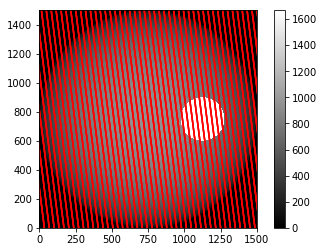

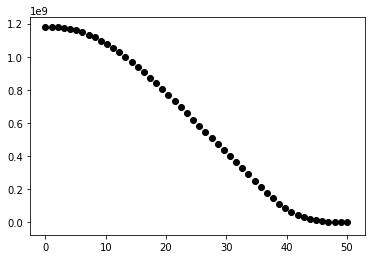

Success.


In [17]:
# Save the ingress slicing plot
plt.savefig('ingress.pdf')
plt.show()

# Save the integrated slices in the form of a lightcurve to each textfile.
plotrange=np.linspace(0, len(bin_values), num=Nslices)
if debugging_enabled == False:
    file_out = open('ingress1.txt','w')
    file_out.write('bin_values' + '\n')
    
    for i in range(Nslices):
        file_out.write(str(bin_values[i]) + '\n')
        total_amount = total_amount - bin_values[i]
        plt.scatter(plotrange[i],total_amount,c='k')
    
    plt.show()
    file_out.close()
    
    file_out = open('uniformingress1.txt','w')
    file_out.write('bin_values' + '\n')
    
    for i in range(Nslices):
        file_out.write(str(bin_values_uniform[i]) + '\n')
        total_amount = total_amount_uniform - bin_values_uniform[i]
    
    file_out.close()
    
    file_out = open('nolimbingress1.txt','w')
    file_out.write('bin_values' + '\n')
    
    for i in range(Nslices):
        file_out.write(str(bin_values_nolimb[i]) + '\n')
        total_amount = total_amount_nolimb - bin_values_nolimb[i]

    file_out.close()
    
else:
    # If debugging enabled, the testing .fits file for slicing only is saved for debugging purposes.
    values_test = np.transpose(values_test)
    hdu = fits.PrimaryHDU(values_test)
    hdu.writeto('new1'+str(time())+'.fits')
    
    for i in range(Nslices):
        total_amount = total_amount - bin_values[i]
        plt.scatter(plotrange[i],total_amount,c='k')
    
    plt.show()

print "Success."

## End Ingress Slicing

# Egress Slicing

This section will perform the same algorithm as the ingress slicing, but with a reversed direction for slicing.

In [18]:
# Plot the model planet and apply the limits.
plt.imshow(np.transpose(image_data), cmap='gray')
plt.colorbar()
if image_limits == True: #Apply limits on output figure
    plt.xlim(0,image_data.shape[0])
    plt.ylim(0,image_data.shape[1])

# Reverse the slicing angle
angle=-angle
angle2=(pi/2)-angle
deficit=image_data.shape[1]-np.abs(np.tan(angle2))*image_data.shape[0]

# Determine the length of each slice
if angle != pi/4 and angle != 0: extra_length=deficit*np.cos(angle)
elif angle == pi/4 or angle == 0: extra_length=0
if angle == pi/2: slice_length=round(image_data.shape[0]*1./Nslices)
else: slice_length=(((image_data.shape[0]*1.0)/np.cos(angle2))+extra_length)/Nslices
print slice_length

# Initialise variables for the slicing algorithm
bin_values=[]
values_test = np.zeros(shape=(image_data.shape[0],image_data.shape[1]))
print "values_test shape = ", values_test.shape
test_amount, total_amount,total_amount_uniform,total_amount_nolimb = 0,0,0,0
stime = time()

33.5164395503
values_test shape =  (1500, 1500)


## Begin slicing

In [19]:
# Define the egress slicing function to be called for all models:
def egress_slicing(Nslices,angle,angle2,slice_length,uniform):
    
    # Initialise variables
    current_bin=0
    nDone, test=0, 0
    x, y=[0,0], [0,0]

    # Loop through each individual slice
    for l in range(Nslices):

        # For each slice, determine the slicing line coordinates and draw each slice on the final plot
        if l != Nslices :
            linelength=(image_data.shape[0]**2+image_data.shape[1]**2)**(0.5)

            offsetx=image_data.shape[0]-(l+1)*slice_length*np.cos(angle2)
            offsety=(l+1)*slice_length*np.sin(angle2)

            x_old, y_old = x, y

            if angle != pi/4 and angle != pi/2:
                x = [offsetx-linelength*np.cos(angle), offsetx+linelength*np.cos(angle)]
                y = [offsety-linelength*np.sin(angle), offsety+linelength*np.sin(angle)]
            elif angle == pi/4:
                x = [round(offsetx-linelength*np.cos(angle)), round(offsetx+linelength*np.cos(angle))]
                y = [round(offsety-linelength*np.sin(angle)), round(offsety+linelength*np.sin(angle))]
            elif angle == pi/2:
                x = [round(offsetx), round(offsetx)]
                y = [round(offsety-linelength*1), round(offsety+linelength*1)]
            
            plt.plot(x, y, 'r')

        # Perform the same slicing algorithm as used with ingress slicing.
        # The only difference is the angle used, but all other trigonometry is the same.
        for i in range(image_data.shape[0]):
            found = False
            if np.any([values_test[i]==0]) == False and angle != pi/2: continue
            for j in range(image_data.shape[1]):
                    if angle == pi/2:
                        if l*np.abs(slice_length) <= i < (l+1)*np.abs(slice_length):
                            if uniform == False: current_bin+=image_data[i,j]
                            elif uniform == True: current_bin+=image_data_uniform[i,j]
                            elif uniform == 'nolimb': current_bin+=image_data_nolimb[i,j]
                            if values_test[i,j] == 0: values_test[i,j] = l+1
                            elif values_test[i,j] != 0: print "Position Error: ", i, j
                            continue
                    else:
                        if values_test[i,j] != 0: continue
                        d=(i-x[0])*(y[1]-y[0])-(j-y[0])*(x[1]-x[0])
                        d_last=(i-x_old[0])*(y_old[1]-y_old[0])-(j-y_old[0])*(x_old[1]-x_old[0])
                        if d>=0 and d_last<=0:
                            found = True
                            if uniform == False: current_bin+=image_data[i,j]
                            elif uniform == True: current_bin+=image_data_uniform[i,j]
                            elif uniform == 'nolimb': current_bin+=image_data_nolimb[i,j]
                            try:
                                if values_test[i,j] == 0: values_test[i,j] = l+1
                            except Exception as e:
                                if test == 0:
                                    print "ERROR: ", i, j
                                    test +=1
                            continue
                        elif found == True:
                            break
                        elif d<0 and d_last<=0:
                            if values_test[i,j] == 0: break
                        elif d>0 and d_last>=0:
                            if values_test[i,j] == 0: break
                        else:
                            print "ERROR!", i, j

        # Save the results to the initialised arrays to be used for plotting.
        if uniform==False: bin_values.append(current_bin)
        elif uniform==True: bin_values_uniform.append(current_bin)
        elif uniform=='nolimb': bin_values_nolimb.append(current_bin)
        current_bin=0

        # Print a timer to estimate completion time.
        nDone +=1
        elapsed = time() - stime
        pct = (float(nDone) / Nslices)* 100
        tLeft = elapsed * (100/pct - 1)
        stdout.write('\r{:06.3f}% {:2d}:{:02d}:{:05.2f} left'.format(pct, int(tLeft/3600), int((tLeft%3600)/60), tLeft%60) + ' ' * 20)
        stdout.flush()
    return "Slicing Complete."

# Call the function for the volcano model.
print egress_slicing(Nslices,angle,angle2,slice_length,uniform=False)

100.000%  0:00:00.00 left                    Slicing Complete.


In [20]:
# Call the function for the limb-darkened model.
values_test = np.zeros(shape=(image_data.shape[0],image_data.shape[1]))
stime = time()
print egress_slicing(Nslices,angle,angle2,slice_length,uniform=True)

100.000%  0:00:00.00 left                    Slicing Complete.


In [21]:
# Call the function for the no-limb-darkening model.
values_test = np.zeros(shape=(image_data.shape[0],image_data.shape[1]))
stime = time()
print egress_slicing(Nslices,angle,angle2,slice_length,uniform='nolimb')

100.000%  0:00:00.00 left                    Slicing Complete.


In [22]:
# Determine the total integrated values.
for t in range(len(image_data.flat)):
    total_amount+=image_data.flat[t]
    total_amount_uniform+=image_data_uniform.flat[t]
    total_amount_nolimb+=image_data_nolimb.flat[t]

for t in range(len(bin_values)):
    test_amount+=bin_values[t]

In [23]:
# Print some diagnostic values for debugging if necessary.
print "total = ", total_amount
print "test = ", test_amount
print "bins = ", bin_values
print "Any 0:", np.any([values_test==0])

for i in range(image_data.shape[0]):
    for j in range(image_data.shape[1]):
        if values_test[i,j]==0:
            print "Zero: ", j, i

total =  1178054715.34
test =  1178054715.34
bins =  [0.0, 0.0, 236362.68815588774, 2871911.6161983013, 6013448.5619740449, 9004714.9398481883, 11847238.235823456, 14539698.563225852, 17083122.949639648, 21343354.37485319, 27852655.084232006, 31575013.596159596, 34229980.019997515, 36169100.482969269, 37529604.648847148, 38339797.765543036, 38527657.433697306, 37803034.429035313, 35057950.69879061, 35182737.886422992, 35931110.368072778, 36530028.720563397, 36976743.756157175, 37276987.156341001, 37427001.88858445, 37427003.40738114, 37276991.727417544, 36977686.154241823, 36529104.832917951, 35931124.498028137, 35182755.460219957, 34285585.806598522, 33238535.731797326, 32041391.626665927, 30695385.179183807, 29200416.524931021, 27552961.402775962, 25759126.18502548, 23814291.626397524, 21720144.478201985, 19476457.276360292, 17082862.849406585, 14539958.663459508, 11847238.235823374, 9004714.9398481008, 6013448.561974016, 2871911.6161983153, 236362.6881558882, 0.0, 0.0]
Any 0: False


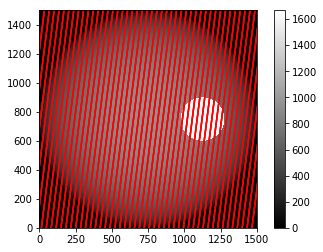

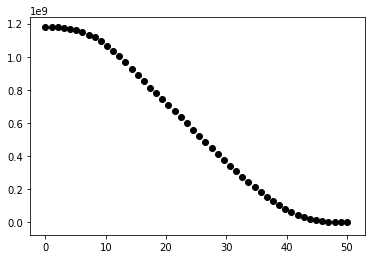

Success.


In [24]:
# Save the results to three egress text files to be used at a later stage.

plt.savefig('egress.pdf')
plt.show()

plotrange=np.linspace(0, len(bin_values), num=Nslices)
if debugging_enabled == False:
    file_out = open('egress1.txt','w')
    file_out.write('bin_values' + '\n')
    
    for i in range(Nslices):
        file_out.write(str(bin_values[i]) + '\n')
        total_amount = total_amount - bin_values[i]
        plt.scatter(plotrange[i],total_amount,c='k')
    
    plt.show()
    file_out.close()
    
    file_out = open('uniformegress1.txt','w')
    file_out.write('bin_values' + '\n')
    
    for i in range(Nslices):
        file_out.write(str(bin_values_uniform[i]) + '\n')
        total_amount = total_amount_uniform - bin_values_uniform[i]

    file_out.close()
    
    file_out = open('nolimbegress1.txt','w')
    file_out.write('bin_values' + '\n')
    
    for i in range(Nslices):
        file_out.write(str(bin_values_nolimb[i]) + '\n')
        total_amount = total_amount_nolimb - bin_values_nolimb[i]

    file_out.close()
else:
    values_test = np.transpose(values_test)
    hdu = fits.PrimaryHDU(values_test)
    hdu.writeto('new2'+str(time())+'.fits')
    
    for i in range(Nslices):
    #file_out.write(str(bin_values[i]) + '\n')
        total_amount = total_amount - bin_values[i]
        plt.scatter(plotrange[i],total_amount,c='k')
    
    plt.show()

print "Success."

## End Egress Slicing

# Blackbody Estimation

A:  0.0
Stellar:  24954892181.9
Planet Thermal:  314268742.64
Planet Refl:  0.0
A:  0.3
Stellar:  24954892181.9
Planet Thermal:  191802996.014
Planet Refl:  32333.1951844
A:  1.0
Stellar:  24954892181.9
Planet Thermal:  0
Planet Refl:  107777.317281


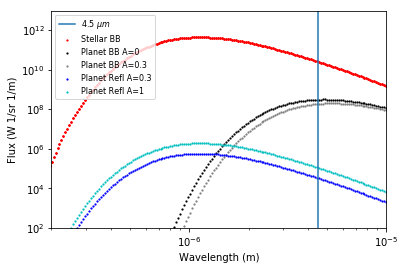

In [25]:
# Clear any plots and define physical constants
plt.clf
h=6.626e-34
c=3.0e8
k=1.38e-23

## TRAPPIST-1 Values:
# If the temperature is known, this can easily be set.
# If not, it can be estimated from a complete heat-redistribution model.
T_P_known=True
if T_P_known == False: T_P = (T_S/(2**0.5))*(R_S/a)**0.5
else: T_P=600
counter = 0
results=[]

# Define the planck function.
def BB_Radiation(T,lambd):
    if T == 0: return 0
    f1=(2*h*c**2)/(lambd**5)
    f2=1/(np.exp((h*c)/(lambd*k*T))-1)
    return f1*f2

# Generate logarithmic x-coordinates
x=np.logspace(-7,-5,num=200)

# Loop through Albedo 0, 0,3 and 1,
for j in range(3):
    if j == 0:
        A = 0.0
    elif j == 1:
        A = 0.3
    elif j == 2:
        A = 1.0
    else:
        print "ERROR!"
    counter = 0
    # For each x-value, determine the flux of the star, reflected planet and emitted planet.
    # Equations are defined in the final report.
    for i in range(len(x)):
        xp=x[i]
        if j == 0 and i == 1:
            plt.scatter(xp,BB_Radiation(T_S,xp),s=5,c='r',lw=0,label='Stellar BB')
            plt.scatter(xp,BB_Radiation(T_P,xp),s=5,c='k',lw=0,label='Planet BB A=0')
        elif j == 1 and i == 1:
            T_P2=T_P*((1-A)**0.25)
            plt.scatter(xp,BB_Radiation(T_P2,xp),s=5,c='#808080',lw=0,label='Planet BB A=0.3')
            frac=A*(R_P/(2*a))**2
            plt.scatter(xp,BB_Radiation(T_S,xp)*frac,s=5,c='b',lw=0,label='Planet Refl A=0.3')
        elif j ==2 and i == 1:
            frac=A*(R_P/(2*a))**2
            plt.scatter(xp,BB_Radiation(T_S,xp)*frac,s=5,c='c',lw=0,label='Planet Refl A=1')
        elif j ==0:
            plt.scatter(xp,BB_Radiation(T_P,xp),s=5,c='k',lw=0)
            plt.scatter(xp,BB_Radiation(T_S,xp),s=5,c='r',lw=0)
        elif j ==1:
            T_P2=T_P*((1-A)**0.25)
            plt.scatter(xp,BB_Radiation(T_P2,xp),s=5,c='#808080',lw=0)
            plt.scatter(xp,BB_Radiation(T_S,xp),s=5,c='r',lw=0)
            frac=A*(R_P/(2*a))**2
            plt.scatter(xp,BB_Radiation(T_S,xp)*frac,s=5,c='b',lw=0)
        elif j ==2:
            plt.scatter(xp,BB_Radiation(T_S,xp),s=5,c='r',lw=0)
            frac=A*(R_P/(2*a))**2
            plt.scatter(xp,BB_Radiation(T_S,xp)*frac,s=5,c='c',lw=0)
        if xp >= 4.5e-6 and counter == 0:
            counter = -1
            T_P2=T_P*((1-A)**0.25)
            frac=A*(R_P/(2*a))**2
            print "A: ", A
            print "Stellar: ", BB_Radiation(T_S,xp)
            results.append(BB_Radiation(T_S,xp))
            print "Planet Thermal: ", BB_Radiation(T_P2,xp)
            if T_P_known == False: results.append(BB_Radiation(T_P2,xp))
            else: results.append(BB_Radiation(T_P,xp))
            print "Planet Refl: ", BB_Radiation(T_S,xp)*frac
            results.append(BB_Radiation(T_S,xp)*frac)
            # In the final array, the positions are defined as the following:
            #0=star,1=thermal,2=reflected, A=0.0
            #3=star,4=thermal,5=reflected, A=0.3
            #6=star,7=thermal,8=reflected, A=1.0
    
# Plot and save the results.
plt.xscale('log')
plt.yscale('log')
plt.xlim(2e-7,1e-5)
plt.ylim(1e2,1e13) #1e4
plt.xlabel('Wavelength (m)')
plt.ylabel('Flux (W 1/sr 1/m)')
plt.axvline(x=4.5e-6, label="4.5 $\mu m$")
plt.savefig('BBcurve_nolegend.pdf')
plt.legend(loc='upper left', fontsize=8)
plt.savefig('BBcurve.pdf')
plt.show()

# Lightcurve Plotting

model time: 178.918335509
equation time:  174.08284499
fraction:  0.00133356719159
radii:  81396900.0 80748186.3623 80748186.3623
2185.57829811 1837.40126258 0.0850968108122
0.00837134616329 0.00703773551522 0.5
[ 0.49162865  0.49165587  0.49168309  0.4917103   0.49173752  0.49176474
  0.49179195  0.49181917  0.49184639  0.4918736   0.49190082  0.49192804
  0.49195525  0.49198247  0.49200969  0.4920369   0.49206412  0.49209134
  0.49211855  0.49214577  0.49217298  0.4922002   0.49222742  0.49225463
  0.49228185  0.49230907  0.49233628  0.4923635   0.49239072  0.49241793
  0.49244515  0.49247237  0.49249958  0.4925268   0.49255402  0.49258123
  0.49260845  0.49263567  0.49266288  0.4926901   0.49271732  0.49274453
  0.49277175  0.49279897  0.49282618  0.4928534   0.49288061  0.49290783
  0.49293505  0.49296226]
-9.12047394759e-05


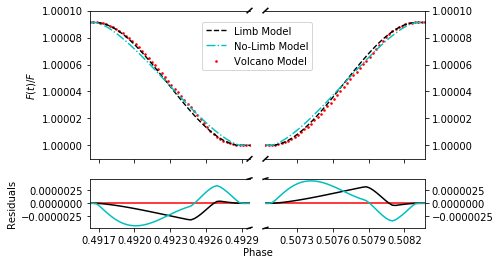

In [26]:
# Import the flux bins from the slicing algorithms.
data1=np.genfromtxt('ingress1.txt', names=True, delimiter=';',dtype=None)
data2=np.genfromtxt('egress1.txt', names=True, delimiter=';',dtype=None)
# techspecs defines various parameters such as the number of slices, slice length, angle etc...
data3=np.genfromtxt('techspecs.txt', names=True, delimiter=';',dtype=None)
uniformdata1=np.genfromtxt('uniformingress1.txt', names=True, delimiter=';',dtype=None)
uniformdata2=np.genfromtxt('uniformegress1.txt', names=True, delimiter=';',dtype=None)
nolimbdata1=np.genfromtxt('nolimbingress1.txt', names=True, delimiter=';',dtype=None)
nolimbdata2=np.genfromtxt('nolimbegress1.txt', names=True, delimiter=';',dtype=None)

###Constants:
# Import various constants from the techspecs file.
Nslices=data3['Nslices']
slice_length=data3['slice_length']
angle=data3['angle']
angle2=(pi/2)-angle
Initial=0.5
###

# Estimate the model ingress time from the verification step performed in the ingress section, if applicable.
p2m=2.0*R_P/x_dimension
velocity2=velocity*np.abs(np.cos(angle+pi/2))
try: model_ingress_time=(ingress_locations[1]-ingress_locations[0])*np.abs(slice_length)*p2m/velocity2
except Exception as e:
    print e
    model_ingress_time=(Nslices)*np.abs(slice_length)*p2m/velocity2
print "model time:", model_ingress_time

# Estimate ingress time from Rauscher 2007
h=a*np.sin((90-inc)*(pi/180))
t_gress1=((R_S+R_P)**2-h**2)**0.5
t_gress2=((R_S-R_P)**2-h**2)**0.5
t_gress=(t_gress1-t_gress2)/velocity
print "equation time: ", t_gress
print "fraction: ", t_gress/P

# Estimate total occultation time:
R_new=R_S*(1-b**2)**0.5
print "radii: ", R_S, R_new, R_S*(1-b**2)**0.5
t_occultation=2*R_new/velocity

# Use equations from Winn (2010) to define full and total time for lightcurve plotting:
k=R_P/R_S
T_total=(P/pi) * np.arcsin(scale_param**-1 * ((1+k)**2-b**2)**0.5 / (np.sin(inc*pi/180)) )
T_full= (P/pi) * np.arcsin(scale_param**-1 * ((1-k)**2-b**2)**0.5 / (np.sin(inc*pi/180)) )

print T_total, T_full, k

# Convert Winn 2010 timings into phases, and half each value:
P_total=T_total*0.5/P
P_full=T_full*0.5/P

# Estimate the flux of the star to normalise the planetary flux
#Take albedo of 0.3 for Earth:
#0=star,1=thermal,2=reflected A=0
#3=star,4=thermal,5=reflected A=0.3
#6=star,7=thermal,8=reflected A=1
# Use model flux of planet to estimate star:
flux_planet=np.sum(uniformdata1['bin_values'])
flux_star=(results[3]*R_S**2/((results[4]+results[5])*R_P**2))*flux_planet

# Apply phase timings from T1b using Winn 2010
plotrange=np.linspace(-P_total+Initial,-P_full+Initial, num=Nslices)
plotrange2=np.linspace(P_full+Initial,P_total+Initial, num=Nslices)
print P_total, P_full, Initial
print plotrange

# Determine necessary parameters to plot lightcurve:
stepdifference=np.abs(plotrange[0]-plotrange[1])
rangedifference=np.abs(plotrange2[0]-plotrange[-1])
Nsteps_needed=int(round(rangedifference/stepdifference))
plotrange3=np.linspace(plotrange[-1]+stepdifference,plotrange2[0]-stepdifference,num=Nsteps_needed, endpoint=False)
total_amount, total_amount_int, total_amount_uni = np.sum(data1['bin_values']), np.sum(data1['bin_values']), np.sum(uniformdata1['bin_values'])

# Open output files to save lightcurve data.
file_out = open('phase_curve1.txt','w')
file_out.write('x_values;flux_values' + '\n')
file_out2 = open('phase_curve2.txt','w')
file_out2.write('x_values;flux_values' + '\n')
file_out3 = open('phase_curve3.txt','w')
file_out3.write('x_values;flux_values' + '\n')
file_out4 = open('graph_specs.txt','w')
#file_out4.write('O_Ratio;P_Ratio;P;flux_star;t_occultation;Initial;Length;Nslices' + '\n')
#file_out4.write(str(O_Ratio)+';'+str(P_Ratio)+';'+str(P)+';'+str(flux_star)+';'+str(t_occultation)+';'+str(Initial)+';'+str(len(data1))+';'+str(Nslices)+ '\n')
file_out4.write('P_total;P_full;P;flux_star;t_occultation;Initial;Length;Nslices' + '\n')
file_out4.write(str(P_total)+';'+str(P_full)+';'+str(P)+';'+str(flux_star)+';'+str(t_occultation)+';'+str(Initial)+';'+str(len(data1))+';'+str(Nslices)+ '\n')
file_out4.close()

# Initialise empty lists to plot data
phase_curve,phase_curve2=[],[]
current_bin=[]
uniform_curve_x=[]
uniform_curve_y=[]
nolimb_curve_x=[]
nolimb_curve_y=[]
residuals1=[]
residuals2=[]
residuals3=[]
residuals4=[]

# Initialise the lightcurve plot:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row',gridspec_kw = {'height_ratios':[3, 1]})
ax1.set_ylim(0.99999, 1.0001)
ax2.set_ylim(0.99999, 1.0001)
ax1.ticklabel_format(axis='y',style='sci',useOffset=False)
ax1.ticklabel_format(axis='x',style='sci',useOffset=False)
ax2.ticklabel_format(axis='x',style='sci',useOffset=False)
ax1.set_xlim(-P_total+Initial,-P_full+Initial)
ax2.set_xlim(P_full+Initial,P_total+Initial)
myLocator = mticker.MultipleLocator(0.0003)
myLocator2 = mticker.MultipleLocator(0.0003)
#myLocator3 = mticker.MultipleLocator(0.000002)
#myLocator4 = mticker.MultipleLocator(0.000002)
ax1.xaxis.set_major_locator(myLocator)
ax2.xaxis.set_major_locator(myLocator2)
#ax3.yaxis.set_major_locator(myLocator3)
#ax4.yaxis.set_major_locator(myLocator4)
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax4.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax1.tick_params(labeltop='off') # don't put tick labels at the top
ax2.yaxis.tick_right()
ax3.yaxis.tick_left()
ax3.tick_params(labeltop='off') # don't put tick labels at the top
ax4.yaxis.tick_right()
plt.subplots_adjust(wspace=0.10)

#############################################
# Simulate a lightcurve for the volcano model
print 1-(total_amount+flux_star)/(flux_star)
for i in range(Nslices):
    total_amount = total_amount - data1['bin_values'][i]
    fractional_flux = (total_amount+flux_star)/(flux_star)
    ax1.scatter(plotrange[i],fractional_flux,s=7, c='r',lw=0)
    if fractional_flux != 1.0: file_out.write(str(plotrange[i])+';'+ str(fractional_flux)+ '\n')
    phase_curve.append(fractional_flux)
    phase_curve2.append(total_amount)
    
for i in range(len(plotrange3)):
    file_out.write(str(plotrange3[i])+';'+ str(1.0)+ '\n') 
    
total_amount = 0

for i in range(Nslices):
    total_amount = total_amount + data2['bin_values'][Nslices-i-1]
    fractional_flux = (total_amount+flux_star)/(flux_star)
    if i == 0: ax2.scatter(plotrange2[i],fractional_flux,s=7, c='r', label='Volcano Model',lw=0)
    else: ax2.scatter(plotrange2[i],fractional_flux,s=7, c='r',lw=0)
    if fractional_flux != 1.0: file_out.write(str(plotrange2[i])+';'+ str(fractional_flux)+ '\n')
    phase_curve.append(fractional_flux)
    phase_curve2.append(total_amount)
    
difference=plotrange2[1]-plotrange2[0]
fractional_flux = (total_amount+flux_star)/(flux_star)
file_out.write(str(plotrange2[-1]+difference)+';'+ str(fractional_flux)+ '\n')

#############################################
# Simulate a lightcurve for the limb-darkened model
total_amount = np.sum(uniformdata1['bin_values'])
   
for i in range(Nslices):
    total_amount = total_amount - uniformdata1['bin_values'][i]
    fractional_flux = (total_amount+flux_star)/(flux_star)
    if fractional_flux != 1.0: file_out2.write(str(plotrange[i])+';'+ str(fractional_flux)+ '\n')
    uniform_curve_x.append(plotrange[i])
    uniform_curve_y.append(fractional_flux)
    residuals1.append(-fractional_flux+phase_curve[i])
    
for i in range(len(plotrange3)):
    file_out2.write(str(plotrange3[i])+';'+ str(1.0)+ '\n') 
    
total_amount = 0
    
for i in range(Nslices):
    total_amount = total_amount + uniformdata2['bin_values'][Nslices-i-1]
    fractional_flux = (total_amount+flux_star)/(flux_star)
    if fractional_flux != 1.0: file_out2.write(str(plotrange2[i])+';'+ str(fractional_flux)+ '\n')
    uniform_curve_x.append(plotrange2[i])
    uniform_curve_y.append(fractional_flux)
    residuals2.append(-fractional_flux+phase_curve[Nslices+i])

ax1.plot(uniform_curve_x,uniform_curve_y,'--',c='k',lw=1.4)
ax2.plot(uniform_curve_x,uniform_curve_y,'--',c='k', label='Limb Model',lw=1.4)
ax1.set_ylabel('$F(t)/F$')

fractional_flux = (total_amount+flux_star)/(flux_star)
file_out2.write(str(plotrange2[-1]+difference)+';'+ str(fractional_flux)+ '\n')

#############################################
# Simulate a lightcurve for the no-limb-darkening model
total_amount = np.sum(nolimbdata1['bin_values'])
for i in range(Nslices):
    total_amount = total_amount - nolimbdata1['bin_values'][i]
    fractional_flux = (total_amount+flux_star)/(flux_star)
    if fractional_flux != 1.0: file_out3.write(str(plotrange[i])+';'+ str(fractional_flux)+ '\n')
    nolimb_curve_x.append(plotrange[i])
    nolimb_curve_y.append(fractional_flux)
    residuals3.append(-fractional_flux+phase_curve[i])
    
for i in range(len(plotrange3)):
    file_out3.write(str(plotrange3[i])+';'+ str(1.0)+ '\n') 
    
total_amount = 0

for i in range(Nslices):
    total_amount = total_amount + nolimbdata2['bin_values'][Nslices-i-1]
    fractional_flux = (total_amount+flux_star)/(flux_star)
    if fractional_flux != 1.0: file_out3.write(str(plotrange2[i])+';'+ str(fractional_flux)+ '\n')
    nolimb_curve_x.append(plotrange2[i])
    nolimb_curve_y.append(fractional_flux)
    residuals4.append(-fractional_flux+phase_curve[Nslices+i])

ax1.plot(nolimb_curve_x,nolimb_curve_y,'-.',c='c',lw=1.4)
ax2.plot(nolimb_curve_x,nolimb_curve_y,'-.',c='c', label='No-Limb Model',lw=1.4)
fractional_flux = (total_amount+flux_star)/(flux_star)
file_out3.write(str(plotrange2[-1]+difference)+';'+ str(fractional_flux)+ '\n')

# Plot the lightcurve data: 
ax1.set_xlabel('Phase')
ax3.set_ylabel('Residuals')
straightline=np.linspace(0,0,num=Nslices)
residuals11=np.array(residuals1)*-1
residuals22=np.array(residuals2)*-1
residuals33=np.array(residuals3)*-1
residuals44=np.array(residuals4)*-1
ax3.plot(plotrange,straightline,c='r')
ax4.plot(plotrange2,straightline,c='r')
ax3.plot(plotrange,residuals11,c='k')
ax4.plot(plotrange2,residuals22,c='k')
ax3.plot(plotrange,residuals33,c='c')
ax4.plot(plotrange2,residuals44,c='c')
ax1.xaxis.set_label_coords(1.05, -0.6)

d = .015 # how big to diagonal the diagonal lines in axes coordinates
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d,1+d), (-d,+d), **kwargs)
ax1.plot((1-d,1+d),(1-d,1+d), **kwargs)

kwargs.update(transform=ax2.transAxes) 
ax2.plot((-d,+d), (1-d,1+d), **kwargs)
ax2.plot((-d,+d), (-d,+d), **kwargs)

kwargs = dict(transform=ax3.transAxes, color='k', clip_on=False)
ax3.plot((1-d,1+d), (-d,+d), **kwargs)
ax3.plot((1-d,1+d),(1-d,1+d), **kwargs)

kwargs.update(transform=ax4.transAxes) 
ax4.plot((-d,+d), (1-d,1+d), **kwargs)
ax4.plot((-d,+d), (-d,+d), **kwargs)

# Plot and show final lightcurve:
ax2.legend(fontsize='medium',loc=(-0.40,+0.6))
plt.savefig('final_lightcurve.pdf',bbox_inches='tight')
plt.show()
file_out.close()
file_out2.close()
file_out3.close()

In [27]:
# Plot outputs to various variables for debugging only:
T_total=(P/pi) * np.arcsin(scale_param**-1 * ((1+k)**2-b**2)**0.5 / (np.sin(inc*pi/180)) )
T_full=(P/pi) * np.arcsin(scale_param**-1 * ((1-k)**2-b**2)**0.5 / (np.sin(inc*pi/180)) )
print (T_total-T_full)/2
print T_total, T_full
print 0.5-T_full/(2*P)-(T_total-T_full)/(2*P)
print P, scale_param,k,b,inc

174.088517767
2185.57829811 1837.40126258
0.491628653837
130539.237984 20.5 0.0850968108122 0.126 89.65


# Noisy Data Simulation

SNR_JWST:  19.912573537
Signal:  9.12047394759e-05
t_occultation 2013.34712641
4
nbins:  58
SD:  34.8822115202


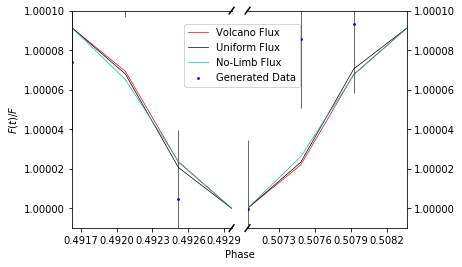

In [28]:
# Plot a graph ready to simulate JWST data:
plt.clf()
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', sharey='row')
ax1.set_ylim(0.99999, 1.0001)
ax2.set_ylim(0.99999, 1.0001)
ax1.ticklabel_format(axis='y',style='sci',useOffset=False)
ax1.set_xlim(-P_total+Initial,-P_full+Initial)
ax2.set_xlim(P_full+Initial,P_total+Initial)
myLocator = mticker.MultipleLocator(0.0003)
myLocator2 = mticker.MultipleLocator(0.0003)
#myLocator3 = mticker.MultipleLocator(0.000002)
#myLocator4 = mticker.MultipleLocator(0.000002)
ax1.xaxis.set_major_locator(myLocator)
ax2.xaxis.set_major_locator(myLocator2)
#ax3.yaxis.set_major_locator(myLocator3)
#ax4.yaxis.set_major_locator(myLocator4)
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
ax1.tick_params(labeltop='off')
ax2.yaxis.tick_right()
plt.subplots_adjust(wspace=0.10)
ax1.set_xlabel('Phase')
ax1.set_ylabel('$F(t)/F$')
ax1.xaxis.set_label_coords(1.05, -0.1)
d = .015 
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1-d,1+d), (-d,+d), **kwargs)
ax1.plot((1-d,1+d),(1-d,1+d), **kwargs)
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d,+d), (1-d,1+d), **kwargs)
ax2.plot((-d,+d), (-d,+d), **kwargs)

# Convert from spitzer to JWST and generate data.
manual_input=False # Enables manually determining sigma_pp. If False, this will be estimated from SNR and cadence.
include_middle=True # Include the fully occulted region. If False, only ingress/egress is included.
include_extra=True # Include extra region before and after occultation.
modify_occultations=False # If true, Spitzer SNR will be scaled to estimate a single occultation
N_occultations=20 # No. Spitzer occultations
Spit_sig=150. # Spitzer signal and noise estimation.
Spit_noise=50.
if manual_input==True:
    SD=75*1e-6
    cadence=30.0
    nbins=int(round(t_gress/cadence))
    nbins2=int(round(t_occultation/cadence))
else:
    A_JWST=25. #Area of JWST
    A_SPITZER=pi*(0.85/2)**2
    SNR_S=3.0 
    # If true, scales the spitzer noise to a single occultation.
    if modify_occultations==True:
        Spit_noise=Spit_noise*(N_occultations)**0.5
        SNR_S=Spit_sig/Spit_noise
        print "SNR_S: ", SNR_S
    SNR_JWST=SNR_S*(A_JWST/A_SPITZER)**0.5 # Scales SNR to JWST.
    print "SNR_JWST: ", SNR_JWST
    # Estimates the signal of the occultation from the model.
    Signal=-1+(np.sum(data1['bin_values'])+flux_star)/flux_star 
    print "Signal: ", Signal
    Noise=Signal/SNR_JWST
    SD_total=Noise
    # This is the candence between each measurement.
    cadence=40.
    nbins=int(round(t_gress/cadence))
    nbins2=int(round(t_occultation/cadence))
    print "t_occultation", t_occultation
    nbinstotal=nbins*2+nbins2
    print nbins
    print "nbins: ", nbinstotal
    # SD is the value of sigma per point.
    SD=SD_total*(nbinstotal)**0.5
    # SD=0.1*1e-6 # Sometimes the SD was manually set here to a small value for debugging the MCMC later on.
    print "SD: ", SD*1e6
# Opens output files to save generated data.
file_out = open('generated_data1.txt','w')
file_out.write('x_values;flux_values' + '\n')
file_out2 = open('generated_data_nomid.txt','w')
file_out2.write('x_values;flux_values' + '\n')
# Generate a linear interpolation for each model.
interpolation_data=np.genfromtxt('phase_curve1.txt', names=True, delimiter=';',dtype=None)
f2 = interp1d(interpolation_data['x_values'], interpolation_data['flux_values'])#, kind='cubic')
interpolation_data=np.genfromtxt('phase_curve2.txt', names=True, delimiter=';',dtype=None)
f22 = interp1d(interpolation_data['x_values'], interpolation_data['flux_values'])#, kind='cubic')
interpolation_data=np.genfromtxt('phase_curve3.txt', names=True, delimiter=';',dtype=None)
f23 = interp1d(interpolation_data['x_values'], interpolation_data['flux_values'])#, kind='cubic')

# This section will generate and save randomly generated data using the above
# calculated SD and this will be performed for the volcano model.

xnew = np.linspace(interpolation_data['x_values'][0], plotrange[-1], num=nbins, endpoint=True)
xnew2 = np.linspace(plotrange2[0], plotrange2[-1], num=nbins, endpoint=True)
if include_extra==True:
    xnew4 = np.linspace(plotrange[0]+(plotrange[-1]-plotrange2[0]), plotrange[0], num=nbins2)
    for i in range(len(xnew4)):
        random_point=np.random.normal(loc=f2(xnew[0]), scale=SD)
        file_out.write(str(xnew4[i])+';'+ str(random_point)+ '\n')
for i in range(len(xnew)):
    random_point=np.random.normal(loc=f2(xnew[i]), scale=SD)
    ax1.scatter(xnew[i],random_point,c='b',s=8,lw=0,zorder=2)
    ax1.errorbar(xnew[i],random_point,yerr=SD,c='#696969',lw=1,zorder=1)#,s=6,lw=0)
    file_out.write(str(xnew[i])+';'+ str(random_point)+ '\n')
    file_out2.write(str(xnew[i])+';'+ str(random_point)+ '\n')
if include_middle==True: #only writes to middle section
    xnew3 = np.linspace(plotrange[-1], plotrange2[0], num=nbins2, endpoint=False)
    for i in range(len(xnew3)):
        random_point=np.random.normal(loc=f2(xnew3[i]), scale=SD)
        file_out.write(str(xnew3[i])+';'+ str(random_point)+ '\n')
for i in range(len(xnew2)):
    random_point=np.random.normal(loc=f2(xnew2[i]), scale=SD)
    if i == 0: ax2.scatter(xnew2[i],random_point,c='b',s=8,lw=0,label='Generated Data',zorder=2)
    else: ax2.scatter(xnew2[i],random_point,c='b',s=8,lw=0,zorder=2)
    ax2.errorbar(xnew2[i],random_point,yerr=SD,c='#696969',lw=1,zorder=1)
    file_out.write(str(xnew2[i])+';'+ str(random_point)+ '\n')
    file_out2.write(str(xnew2[i])+';'+ str(random_point)+ '\n')
if include_extra==True:
    xnew5 = np.linspace(plotrange2[-1], plotrange2[-1]+(plotrange2[0]-plotrange[-1]), num=nbins2, endpoint=False)
    for i in range(len(xnew5)):
        random_point=np.random.normal(loc=f2(xnew2[-1]), scale=SD)
        file_out.write(str(xnew5[i])+';'+ str(random_point)+ '\n')

# Plot the resulting random data for the ingress and egress only.
# To plot the full lightcurve, the file generated_data1.txt can be applied.
ax1.plot(xnew, f2(xnew), '-', c='r',lw=0.7,label="Volcano Model")
ax2.plot(xnew2, f2(xnew2), '-', c='r',lw=0.7,label="Volcano Flux")
ax1.plot(xnew, f22(xnew), '-', c='k',lw=0.7,label="Uniform Model")
ax2.plot(xnew2, f22(xnew2), '-', c='k',lw=0.7,label="Uniform Flux")
ax1.plot(xnew, f23(xnew), '-', c='c',lw=0.7,label="No-Limb Model")
ax2.plot(xnew2, f23(xnew2), '-', c='c',lw=0.7,label="No-Limb Flux")
ax2.legend(fontsize='medium',loc=(-0.40,+0.65))
plt.savefig('generated_lightcurve.pdf',bbox_inches='tight')
plt.show()
file_out.close()
file_out2.close()

In [29]:
# Define a function to calculate the chi2 for each model with the random data if necessary.
def chi2_calculation (inputfile,interpolation,sigma_value):
    chi2file=np.genfromtxt(str(inputfile)+'.txt', names=True, delimiter=';',dtype=None)
    chi2_list=[]
    for i in range(len(chi2file)):
        difference=chi2file['flux_values'][i]-interpolation(float(chi2file['x_values'][i]))
        chi2_list.append(difference**2/sigma_value**2)
    return np.sum(chi2_list)/(len(chi2file)-2), np.sum(chi2_list), (2*np.sum(chi2_list))**0.5,len(chi2file),np.exp(-0.5*np.sum(chi2_list))

# Uncomment these lines to perform the chi2 test:
#print "Reduced chi2 with Volcano Model: ", chi2_calculation('generated_data1',f2,SD)
#print "Reduced chi2 with Uniform Model: ",chi2_calculation('generated_data1',f22,SD)
#print "Reduced chi2 with No Limb-Darkening Model: ",chi2_calculation('generated_data1',f23,SD)

# Degeneracy with Eccentricity

The next section will plot the degenerate eccentricity results from the MCMC if needed.

Use this: [65786.525001015951, 65269.618991999996, 64752.712982984034, 65269.618991999996, 65786.525001015951] [48.200245862989654, 28.057535610547685, 48.200245642213964, 28.057535610547685, 48.200245862989654] (0, 90, 180, 270, 360)


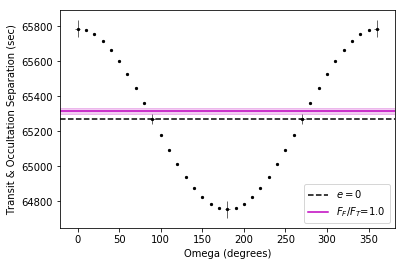

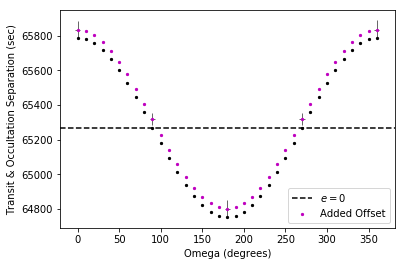

[[30.82, 32.28, 28.88, 31.65, 31.78], [29.2, 30.67, 30.48, 30.14, 30.19]]


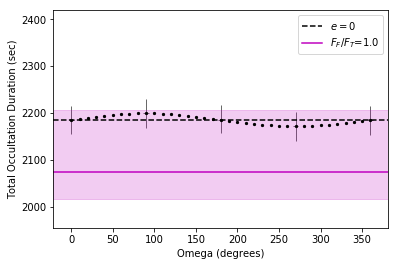

[[27.68, 27.52, 26.5, 28.2, 26.74], [33.17, 33.42, 32.18, 31.95, 32.47]]


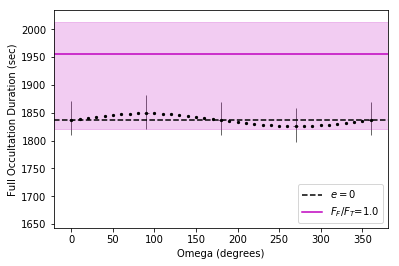

In [30]:
savefigures=False
plt.clf()
eccentricity=0.00622
angle=0,90,180,270,360
angle2=np.arange(361,step=10)
scale_param=20.50
sigma_scale_param=0.16

'''
sigma_P=0.60*1e-6*3600*24 #in seconds
sigma_e=0.00304 
sigma_w=34.24*pi/180 #in radians
#sigma_a=0.34*1e-3*AU #in meters
#sigma_Rs=0.0036*R_Sun #in meters
#sigma_inc=0.27 #in degrees
sigma_b=0.092
'''

# Define errors on each parameter, using optimal values from the T1 system.
sigma_P=0.60*1e-6*3600*24 #in seconds
sigma_e=0.00058
sigma_w=3.11*pi/180 #in radians
#sigma_a=0.34*1e-3*AU #in meters
#sigma_Rs=0*0.0036*R_Sun #in meters
#sigma_inc=0.27 #in degrees
sigma_b=0.078

delta_t=[]
sigma_t=[]
sigma_t_position=[]

# Plots the result for the midpoint shift from the volcano model.
F1=0.50037
S1_n=0.00015
S1_p=0.00012

# Calculate the errors for the delta T values:
for i in angle2:
    conv=pi/180
    omega=i*conv
    yval=(P/2)*(1+(4./pi)*eccentricity*np.cos(omega))
    delta_t.append(yval)
    if i in angle:
        eq1=sigma_P*(0.5)*(1+(4./pi)*eccentricity*np.cos(omega))
        eq2=sigma_e*(P/2)*((4./pi)*np.cos(omega))
        eq3=sigma_w*(P/2)*((-4./pi)*eccentricity*np.sin(omega))
        sigma_t_position.append(yval)
        sigma_t.append((eq1**2+eq2**2+eq3**2)**0.5)

# Print the sigma values to use in the midpoint MCMC generation if needed.
print "Use this:", sigma_t_position, sigma_t, angle

# Plot the results:
plt.scatter(angle2,delta_t,c='k',s=5,zorder=2)
plt.axhline(P/2,c='k',linestyle='--',label='$e=0$')
plt.axhline(P*F1,c='m',label='$F_F/F_T$=1.0')
plt.axhspan(P*(F1-S1_n), P*(F1+S1_p), color='m', alpha=0.20)
plt.xlabel('Omega (degrees)')
plt.ylabel('Transit & Occultation Separation (sec)')
plt.legend(loc='lower right')
if savefigures==True: plt.savefig('Midpoint_Time_noerrors.pdf')
plt.errorbar(angle,sigma_t_position,xerr=sigma_w*180./pi,yerr=sigma_t,c='#696969',lw=1,zorder=1,ls='none')
if savefigures==True: plt.savefig('Midpoint_Time.pdf')
plt.show()

# Plot the combined eccentricity + volcano results:
peakdifference=P*F1-P*0.5
delta_t2=[]
sigma_t2=[]
sigma_t2_position=[]
counter=0
for i in range(len(angle2)):
    yval=peakdifference+delta_t[i]
    delta_t2.append(peakdifference+delta_t[i])
    if angle2[i] in angle:
        sigma_t2_position.append(yval)
        counter+=1
    
# Results from the midpoint MCMC generation error values:
sigma_t2_p=[50.79,32.60,52.34,31.60,48.79]
sigma_t2_n=[50.80,34.02,52.33,34.76,53.67]

# Plot the combined results:
sigma_t2=[sigma_t2_p,sigma_t2_n]
plt.scatter(angle2,delta_t,c='k',s=5,zorder=2)
plt.scatter(angle2,delta_t2,c='m',s=5,zorder=2,label='Added Offset')
plt.errorbar(angle,sigma_t2_position,xerr=sigma_w*180./pi,yerr=sigma_t2,c='#696969',lw=1,zorder=1,ls='none')
plt.axhline(P/2,c='k',linestyle='--',label='$e=0$')
plt.xlabel('Omega (degrees)')
plt.ylabel('Transit & Occultation Separation (sec)')
plt.legend(loc='lower right')
if savefigures==True: plt.savefig('Midpoint_Time_combined.pdf')
plt.show()

#MCMC results for total occultation:
F1=0.00794 *2
S1_n = 0.00022 *2
S1_p = 0.00051 *2

delta_t3=[]
sigma_t3=[]
sigma_t3_position=[]
for i in angle2:
    conv=pi/180
    omega=i*conv
    yval=(T_total)*(1-eccentricity**2)**0.5/(1-eccentricity*np.sin(omega))
    delta_t3.append(yval)
    if i in angle:
        sigma_t3_position.append(yval)
    
# MCMC results for error values:
sigma_t3_p=[30.82,32.28,28.88,31.65,31.78]
sigma_t3_n=[29.20,30.67,30.48,30.14,30.19]
sigma_t3=[sigma_t3_p,sigma_t3_n]
print sigma_t3

# Plots the results:
plt.scatter(angle2,delta_t3,c='k',s=5,zorder=2)
plt.errorbar(angle,sigma_t3_position,xerr=sigma_w*180./pi,yerr=sigma_t3,c='#696969',lw=1,zorder=1,ls='none')
plt.axhline(T_total,c='k',linestyle='--',label='$e=0$')
plt.axhline(P*F1,c='m',label='$F_F/F_T$=1.0')
plt.axhspan(P*(F1-S1_n), P*(F1+S1_p), color='m', alpha=0.20)
plt.xlabel('Omega (degrees)')
plt.ylabel('Total Occultation Duration (sec)')
plt.ylim(min(delta_t3)*0.9,max(delta_t3)*1.1)
plt.legend(loc='upper right')
if savefigures==True: plt.savefig('Duration_Time.pdf')
plt.show()

# MCMC results for the full occultation time:
F1= 0.00749*2
S1_n=  0.000516*2
S1_p=  0.000218*2

delta_t3=[]
sigma_t3=[]
sigma_t3_position=[]
for i in angle2:
    conv=pi/180
    omega=i*conv
    yval=(T_full)*(1-eccentricity**2)**0.5/(1-eccentricity*np.sin(omega))
    delta_t3.append(yval)
    if i in angle:
        sigma_t3_position.append(yval)
    
# MCMC results for error values:
sigma_t3_p=[27.68,27.52,26.50,28.20,26.74]
sigma_t3_n=[33.17,33.42,32.18,31.95,32.47]
sigma_t3=[sigma_t3_p,sigma_t3_n]
print sigma_t3

plt.scatter(angle2,delta_t3,c='k',s=5,zorder=2)
plt.errorbar(angle,sigma_t3_position,xerr=sigma_w*180./pi,yerr=sigma_t3,c='#696969',lw=1,zorder=1,ls='none')
plt.axhline(T_full,c='k',linestyle='--',label='$e=0$')
plt.axhline(P*F1,c='m',label='$F_F/F_T$=1.0')
plt.axhspan(P*(F1-S1_n), P*(F1+S1_p), color='m', alpha=0.20)
plt.xlabel('Omega (degrees)')
plt.ylabel('Full Occultation Duration (sec)')
plt.ylim(min(delta_t3)*0.9,max(delta_t3)*1.1)
plt.legend(loc='lower right')
if savefigures==True: plt.savefig('Duration_Time2.pdf')
plt.show()

In [31]:
# Print values for debugging only:
print t_occultation*pi/P,t_occultation*pi/P-(t_occultation*pi/P)**3/6,np.sin(t_occultation*pi/P)
g=eccentricity
print g
inc2=90.
print np.arctan(inc2*pi/180*g**2)
print np.arctan(inc2*pi/180*g**2)*np.arcsin(t_occultation/P)**2
extrafactor=(t_occultation)**3 * 8
print g*1./6 *(2*pi/(4*P))**2 * (extrafactor), g*t_occultation*2,t_occultation*2
print 1./6 *(2*pi/(4*P))**2

0.0484537571931 0.0484347975077 0.0484347997333
0.00622
6.07715965348e-05
1.44574020063e-08
0.00980037528735 25.0460382525 4026.69425281
2.41327246269e-11


# Image Reconstruction

Starting ingress slicing...
Progress: |██████████████████████████████████████████████████| 100.0% Complete()
Starting egress slicing...
Progress: |██████████████████████████████████████████████████| 100.0% Complete()
min pix:  102.677101718
Filename: reconstruction1521807000.31.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (1500, 1500)   int64   
<type 'numpy.ndarray'>
(1500, 1500)


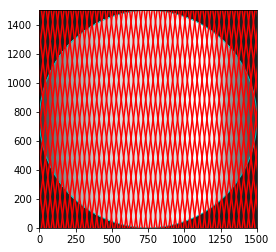

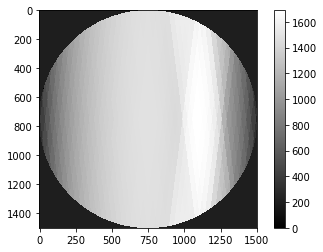

Success.


In [32]:
# Define a progress bar for image reconstruction:
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█'):
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    stdout.write('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix))
    stdout.flush()
    if iteration == total: 
        print()

# Defines the prior of the planet being a circle:
fig, ax = plt.subplots()
plt.axis([0,data3['x'],0,data3['y']])
x_min = 0
x_max = data3['x']
y_min = 0
y_max = data3['y']
circle_x = (x_max-x_min)/2.
circle_y = (y_max-y_min)/2.
circ=plt.Circle((circle_x,circle_y), radius=data3['x']/2., color='c', fill=False)
ax.add_artist(circ)

# Defines slicing length and angle as prior knowledge.
slice_length=data3['slice_length']
angle=data3['angle']
angle2=(pi/2)-angle

# Determine difference between bin values (flux) for the volcano model:
current_bin.append(0)
for i in range(Nslices*2):
    if i == 0:
        continue
    difference = phase_curve2[i]-phase_curve2[i-1]
    current_bin.append(np.abs(difference))

# Initialise variables
test_amount=0
x=[0,0]
y=[0,0]
nDone=0
stime = time()
total_pixels=0
test=0
values_test = np.zeros(shape=(data3['x'],data3['y']))
values_test2 = np.zeros(shape=(data3['x'],data3['y']))
#reconstruction_test = np.zeros(shape=(data3['x'],data3['y']))
reconstruction_test = np.full((data3['x'],data3['y']), 0, dtype=int)

print "Starting ingress slicing..."

###

# Define reconstruction function to be called for ingress and egress.
# This is heavily based on the previous slicing algorithm, but instead build an image from slices.
def ingress_reconstruction(Nslices,angle,angle2,slice_length,ingress,multiply):
    
    # Initialise variables
    nDone, test, total_pixels=0, 0, 0
    error=False
    min_pix=1e9
    x, y=[0,0], [0,0]

    
    for l in range(Nslices):
        if error == True: break
        # For each slice, plot the slicing lines as previously.
        if l != Nslices :
            linelength=(data3['x']**2+data3['y']**2)**(0.5)

            if ingress == True:
                offsetx=(l+1)*slice_length*np.cos(angle2)
                offsety=-(l+1)*slice_length*np.sin(angle2)
            elif ingress == False:
                offsetx=data3['x']-(l+1)*slice_length*np.cos(angle2)
                offsety=(l+1)*slice_length*np.sin(angle2)

            x_old, y_old = x, y

            x = [offsetx-linelength*np.cos(angle), offsetx+linelength*np.cos(angle)]
            y = [offsety-linelength*np.sin(angle), offsety+linelength*np.sin(angle)]

            plt.plot(x, y, 'r')

        for i in range(data3['x']):
            found = False
            if error == True: break
            if np.any([values_test[i]==0]) == False: continue
            for j in range(data3['y']):
                    if values_test[i,j] != 0: continue
                    # Determine for each pixel if it lies within the slicing lines and within
                    # the dimensions of the circular planet.
                    d=(i-x[0])*(y[1]-y[0])-(j-y[0])*(x[1]-x[0])
                    d_last=(i-x_old[0])*(y_old[1]-y_old[0])-(j-y_old[0])*(x_old[1]-x_old[0])
                    d2=(i - circle_x)**2 + (j - circle_y)**2
                    if d>0 and d_last<=0:
                        found = True
                        if d2**0.5 < x_max/2.:
                            # If pixel lies within range, add +1 to the total area in the slice.
                            # This is used to find delta A.
                            total_pixels+=1.0
                        try:
                            if values_test[i,j] == 0: values_test[i,j] = l+1
                        except Exception as e:
                            if test == 0:
                                print "ERROR: ", i, j
                                test +=1
                        continue
                    # Use the same time-saving algorithms as previous:
                    elif found == True: break
                    elif d<0 and d_last<=0:
                        if values_test[i,j] == 0: break
                    elif d>0 and d_last>=0:
                        if values_test[i,j] == 0: break
                    else:
                        print "ERROR!"
                        error=True
                        break
        if total_pixels==0:
            pixel_value = 0
        else:
            try:
                # Average the flux across the entire area for each slice.
                if ingress == True: pixel_value=current_bin[l]/total_pixels
                elif ingress == False: pixel_value=current_bin[Nslices*2-l-1]/total_pixels
                if pixel_value <= min_pix:
                    min_pix=pixel_value
            except Exception as e:
                print e
                pixel_value=1
        total_pixels=0

        # Repear the process to assign each pixel in a slice with the average intensity.
        for i in range(data3['x']):
            found = False
            if error == True: break
            if np.any([values_test2[i]==0]) == False: continue
            for j in range(data3['y']):
                    if values_test2[i,j] != 0: continue
                    d=(i-x[0])*(y[1]-y[0])-(j-y[0])*(x[1]-x[0])
                    d_last=(i-x_old[0])*(y_old[1]-y_old[0])-(j-y_old[0])*(x_old[1]-x_old[0])
                    d2=(i - circle_x)**2 + (j - circle_y)**2
                    if d>0 and d_last<=0:# and d2**0.5 < x_max/2.:
                        found = True
                        if d2**0.5 < x_max/2.:
                            # Can additively or multiplicatively combine flux for each pixel.
                            if ingress == True or multiply == False: reconstruction_test[i,j] += pixel_value
                            elif ingress == False: reconstruction_test[i,j] = pixel_value * reconstruction_test[i,j]
                            else:
                                error=True
                                print "ERROR!"
                        try:
                            if values_test2[i,j] == 0: values_test2[i,j] = l+1
                        except Exception as e:
                            if test == 0:
                                print "ERROR: ", i, j
                                test +=1
                        continue
                    elif found == True: break
                    elif d<0 and d_last<=0:
                        if values_test2[i,j] == 0: break
                    elif d>0 and d_last>=0:
                        if values_test2[i,j] == 0: break
                    else:
                        print "ERROR!"
                        error=True
                        break
        
        printProgressBar(l + 1, Nslices, prefix = 'Progress:', suffix = 'Complete', length = 50)
    return min_pix

# Call function for the ingress reconstruction.
printProgressBar(0, Nslices, prefix = 'Progress:', suffix = 'Complete', length = 50)
min_pix = ingress_reconstruction(Nslices,angle,angle2,slice_length,ingress=True,multiply=False)

# Repeat for the egress reconstruction.
print "Starting egress slicing..."
values_test = np.zeros(shape=(data3['x'],data3['y']))
values_test2 = np.zeros(shape=(data3['x'],data3['y']))
angle=-angle
angle2=(pi/2)-angle
slice_length=np.abs(slice_length)
stime=time()
total_pixels=0
printProgressBar(0, Nslices, prefix = 'Progress:', suffix = 'Complete', length = 50)
min_pix2 = ingress_reconstruction(Nslices,angle,angle2,slice_length,ingress=False,multiply=False)

# Find the minimum picel value, and define region outside planetary radius as this average value.
# This improves the contrast of the reconstructed planet within DS9.
print "min pix: ", min_pix
lowest_value=1e9
for i in range(x_dimension): #loop through x pixels
    for j in range(y_dimension): #loop through y pixels
        d=(i - circle_x)**2 + (j - circle_y)**2 #calculate distance of pixel to circle centre
        if d**0.5 < x_dimension/2.: #determine if distance lies inside radial size of planet
            if reconstruction_test[i,j] < lowest_value:
                lowest_value=reconstruction_test[i,j]
for i in range(x_dimension): #loop through x pixels
    for j in range(y_dimension): #loop through y pixels
        d=(i - circle_x)**2 + (j - circle_y)**2 #calculate distance of pixel to circle centre
        if d**0.5 > x_dimension/2.: #determine if distance lies outside radial size of planet
            reconstruction_test[i,j]=lowest_value

# Save reconstructed fits file.
reconstruction_test = np.transpose(reconstruction_test)
hdu = fits.PrimaryHDU(reconstruction_test)
hdu.writeto('reconstruction'+str(stime)+'.fits')

# Save debugging fits file.
values_test2 = np.transpose(values_test2)
hdu = fits.PrimaryHDU(values_test2)
hdu.writeto('values'+str(stime)+'.fits')

hdu_list = fits.open('reconstruction'+str(stime)+'.fits')
hdu_list.info()
image_data = hdu_list[0].data
print(type(image_data))
print(image_data.shape)
hdu_list.close()
plt.imshow(image_data, cmap='gray')

plt.savefig('combination.pdf')
plt.show()
plt.clf()
plt.imshow(image_data, cmap='gray')
plt.colorbar()
plt.savefig('reconstructed.pdf')
plt.show()

print "Success."

In [33]:
# Test to make sure all pixels were tested. Should return 'false' if algorithm functioned correctly.
np.any([values_test==0])

False

# Contour Plots

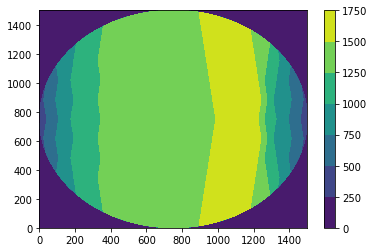

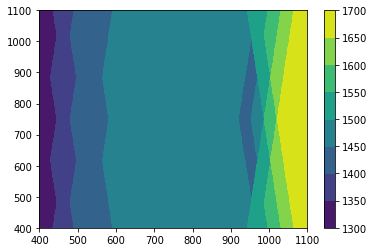

In [34]:
# Define a cropping function to display only inner region.
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

# Degerate and display two contour plots.
# One for the whole model. Another for just the inner region.
x=np.linspace(1,data3['x'],num=data3['x'])
y=np.linspace(1,data3['y'],num=data3['y'])
contours = plt.contourf(x,y,reconstruction_test)
plt.colorbar()
plt.savefig('contour.pdf')
plt.show()
cropvalues=[700.,700.]
reconstruction_test2=crop_center(reconstruction_test,int(cropvalues[0]),int(cropvalues[1]))
x=np.linspace(data3['x']/2-cropvalues[0]/2,data3['x']/2+cropvalues[0]/2,num=int(cropvalues[0]))
y=np.linspace(data3['y']/2-cropvalues[1]/2,data3['y']/2+cropvalues[1]/2,num=int(cropvalues[1]))
contours2 = plt.contourf(x,y,reconstruction_test2)
plt.colorbar()
plt.savefig('contourzoomed.pdf')
plt.show()